# **Project Five - Cherry Leaves ML Pipeline**

## Objectives

* Write here your notebook objective, for example, "Fetch data from Kaggle and save as raw data", or "engineer features for modelling"

## Inputs

* Write here which data or information you need to run the notebook 

## Outputs

* Write here which files, code or artefacts you generate by the end of the notebook 

## Additional Comments

* In case you have any additional comments that don't fit in the previous bullets, please state them here. 



---


## Workflow

- Data Collection
- Data Cleaning
- Data Preprocessing
- Create Pipeline
- Create Neural Network
- Fit Pipeline
- Fit Model
- Evaluate Model
- Predict Live Data

---

## Import list:

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

---

# Change working directory

* We are assuming you will store the notebooks in a subfolder, therefore when running the notebook in the editor, you will need to change the working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [2]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/P-Five-Mildew/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [4]:
current_dir = os.getcwd()
current_dir

'/workspace/P-Five-Mildew'

---

# Data Collection

Section 1 content

There is a data set provided by the customer, it contains 2104 images of healthy cherry leaves and 2104 images of cherry leaves containing powdery mildew.
The dataset will be accessed and downloaded from kaggle. (Insert a link here later)


In [5]:
# Install Kaggle Package
!pip install kaggle

  Using cached kaggle-1.7.4.5-py3-none-any.whl.metadata (16 kB)
  Using cached python_slugify-8.0.4-py2.py3-none-any.whl.metadata (8.5 kB)
  Using cached text_unidecode-1.3-py2.py3-none-any.whl.metadata (2.4 kB)
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached kaggle-1.7.4.5-py3-none-any.whl (181 kB)
Using cached python_slugify-8.0.4-py2.py3-none-any.whl (10 kB)
Using cached text_unidecode-1.3-py2.py3-none-any.whl (78 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4/4 [kaggle]2m3/4 [kaggle]


I need to change the Kaggle configuration directory to the current working directory and set permissions for the Kaggle authentication JSON.


In [6]:
os.environ['KAGGLE_CONFIG_DIR'] = os.getcwd()
! chmod 600 kaggle.json

Now that I have changed the kaggle configuration directory to the current working directory I can download the dataset and use it within Jupyter notebooks.

In [7]:
KaggleDatasetPath = "codeinstitute/cherry-leaves"
DestinationFolder = "inputs/cherry_leaves_dataset"
! kaggle datasets download -d {KaggleDatasetPath} -p {DestinationFolder}

Dataset URL: https://www.kaggle.com/datasets/codeinstitute/cherry-leaves
License(s): unknown
  0%|                                               | 0.00/55.0M [00:00<?, ?B/s]
100%|██████████████████████████████████████| 55.0M/55.0M [00:00<00:00, 1.10GB/s]


Now I need to extract the file from the zip file:

In [8]:
import zipfile
with zipfile.ZipFile(DestinationFolder + '/cherry-leaves.zip', 'r') as zip_ref:
    zip_ref.extractall(DestinationFolder)

os.remove(DestinationFolder + '/cherry-leaves.zip')

### Load and Explore the files

In [9]:
# List top level content:

print(os.listdir(DestinationFolder))

['cherry-leaves']


I will now access both the 'healthy' and 'powdery_mildew' folders to see what is inside.

In [10]:
# Check what subfolders exsit:
print(os.listdir(os.path.join(DestinationFolder, 'cherry-leaves')))

['healthy', 'powdery_mildew']


In [11]:
# Parent Folder
cherry_leaves_path = os.path.join(DestinationFolder, 'cherry-leaves')
print(os.listdir(cherry_leaves_path))

['healthy', 'powdery_mildew']


#### Check size of dataset

I know already the dataset is made up of 2104 healthy images and 2104 powdery_mildew images, but I will check this to make sure it is correct.

In [12]:
for category in os.listdir(cherry_leaves_path):
    category_path = os.path.join(cherry_leaves_path, category)
    if os.path.isdir(category_path):
        num_images = len(os.listdir(category_path))
        print(f'{category}: {num_images} images')

healthy: 2104 images
powdery_mildew: 2104 images


(256, 256)
{'jfif': 257, 'jfif_version': (1, 1), 'jfif_unit': 0, 'jfif_density': (1, 1)}


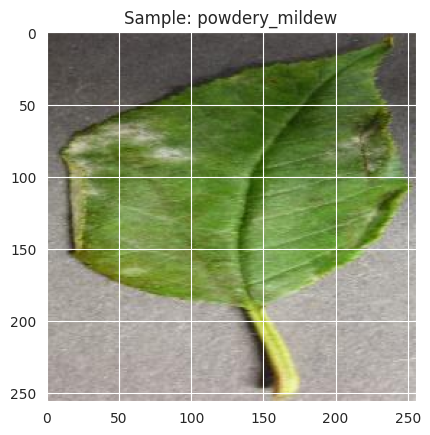

In [13]:
from PIL import Image

# Set category as either 'healthy' or 'powdery_mildew'
image_class = 'powdery_mildew'
image_fodler = os.path.join(cherry_leaves_path, image_class)

# Set counter to integer between 0 and 2103
counter = 12

# Get one image
image_file = os.listdir(image_fodler)[counter]
image_path = os.path.join(image_fodler, image_file)

# Display the image
current_image = Image.open(image_path)
plt.imshow(current_image)
plt.title(f'Sample: {image_class}')

#Check the size of the image
print(current_image.size)
print(current_image.info)


### Check image size of all files:

If all image files are the same size this is acceptable, if not then they will need to be rescaled.

##### Create function to return list of class labels

In [14]:
def return_labels(root_dir):
    label_paths = []
    # Create a loop to loop through each class (Healthy, Powdery_Mildew) and return a list
    for label in os.listdir(root_dir):
        label_path = os.path.join(root_dir, label)
        if os.path.isdir(label_path):
            label_paths.append(label_path)
    return label_paths

In [15]:
# Create an empty set to store a unique image size
# Sets will automatically ignore duplicates, so if the only size is 256x256 then it will only store it once.

label_paths = return_labels(cherry_leaves_path)


def check_image_size(label_dir):
    sizes = set()
    # Create a loop to loop through each class (Healthy, Powdery_Mildew)
    for label_path in label_dir:
        # Loops through each filename inside current class/category
        for file in os.listdir(label_path):
            # Build path to image file
            file_path = os.path.join(label_path, file)
            # Open image using PIL Image and add to sizes object
            with Image.open(file_path) as img:
                sizes.add(img.size)

    print(f"Unique Image Sizes: {sizes}")

check_image_size(label_paths)

Unique Image Sizes: {(256, 256)}


The imagesize is 256x256, this will be acceptable however checking through the handbook notes, 
this will lead to a model larger than 100Mb, therefore resizing the images to 100x100 will allow for a 
smaller trained model. 

In [16]:
# Resize all images to 100x100
# Loop through all images and save their size as 100x100
for label_path in label_paths:
    for file in os.listdir(label_path):
        file_path = os.path.join(label_path, file)
        with Image.open(file_path) as img:
            resized = img.resize((100, 100))
            # Overwrites original size
            resized.save(file_path)

Unique Image Sizes: {(100, 100)}
(100, 100)


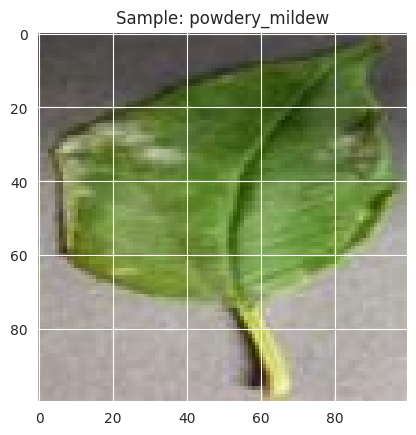

In [17]:
# Check image size:
check_image_size(label_paths)

# Display the same image from before
current_image = Image.open(image_path)
plt.imshow(current_image)
plt.title(f'Sample: {image_class}')
print(current_image.size)

---

### Convert Dataset Into Pandas Series

Before being able to create my Train, Validation and Test sets I will need the data to be in an appropriate format to be able to split the datasets. I will need to convert the datasets into a pandas series allowing the file paths to be associated with a class label.

Create reusable functions to stop repeating code:

In [17]:
def get_image_paths_and_labels(cherry_dir):
    """Return a list of iamge path and class label from subdirectories"""
    # Store each image path with its class label
    dataset = []

    # Create a for loop to loop through all files and add a class label
    for label in os.listdir(cherry_dir):
        label_path = os.path.join(cherry_dir, label)

        # Check to make sure it is a directory 
        if os.path.join(label_path):

            for img_file in os.listdir(label_path):
                img_path = os.path.join(label_path, img_file)

                # Append a tuple of, filepath, class label to list.
                dataset.append((img_path, label))
    dataset = pd.DataFrame(dataset, columns=['image_path', 'label'])
    return dataset


In [18]:
# Check to see if function is working correctly
cherry_df = get_image_paths_and_labels(cherry_leaves_path)
print(cherry_df)
print(cherry_df.shape)

                                             image_path           label
0     inputs/cherry_leaves_dataset/cherry-leaves/hea...         healthy
1     inputs/cherry_leaves_dataset/cherry-leaves/hea...         healthy
2     inputs/cherry_leaves_dataset/cherry-leaves/hea...         healthy
3     inputs/cherry_leaves_dataset/cherry-leaves/hea...         healthy
4     inputs/cherry_leaves_dataset/cherry-leaves/hea...         healthy
...                                                 ...             ...
4203  inputs/cherry_leaves_dataset/cherry-leaves/pow...  powdery_mildew
4204  inputs/cherry_leaves_dataset/cherry-leaves/pow...  powdery_mildew
4205  inputs/cherry_leaves_dataset/cherry-leaves/pow...  powdery_mildew
4206  inputs/cherry_leaves_dataset/cherry-leaves/pow...  powdery_mildew
4207  inputs/cherry_leaves_dataset/cherry-leaves/pow...  powdery_mildew

[4208 rows x 2 columns]
(4208, 2)


---

### Image Montage

From the previous function it is concluded that the only unique image size is 256x256, therefore reshaping and resizing the data is not needed.

The client has asked for an image montage of the data, this will display a grid of images per class. In this case, "healthy" and "powdery_mildew".

In [26]:
# Image Montage Code

# Create sample of healthy cherry leaves
sample_healthy_df = cherry_df[cherry_df['label'] == 'healthy'].sample(16, random_state=25)

# Create sample of unhealthy cherry leaves
sample_mildew_df = cherry_df[cherry_df['label'] == 'powdery_mildew'].sample(16, random_state=25)

def image_montage(sample_df, nrows, ncols, figsize=(20,20), title='Image Montage'):
    num_slots = nrows * ncols
    num_images = len(sample_df)
    
    if num_images > num_slots:
        raise ValueError(f"There are too many images for the montage grid: {num_images} images for only {num_slots} slots."
                "Reduce sample size or increase nrows/ncols.")

    if num_images < num_slots:
        raise ValueError(f"There aren't enough images for the montage grid: {num_images} images for only {num_slots} slots."
                "Increase sample size or decrease nrows/ncols.")

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axes = axes.flatten()

    for i in range(len(sample_df)):
        # Access the row by index
        row = sample_df.iloc[i]
        # Get the corresponding subpot
        ax = axes[i]

        # Open and display image
        img = Image.open(row['image_path'])
        ax.imshow(img)
        ax.set_title(row['label'], fontsize=8)
        ax.axis('off')

    plt.suptitle(title, fontsize=24)
    plt.tight_layout(rect=(0, 0, 1, 0.95))
    plt.show()



In [28]:
image_montage(sample_mildew_df, 3, 4, title='Powdery Mildew Leaves')

ValueError: There are too many images for the montage grid: 16 images for only 12 slots.Reduce sample size or increase nrows/ncols.

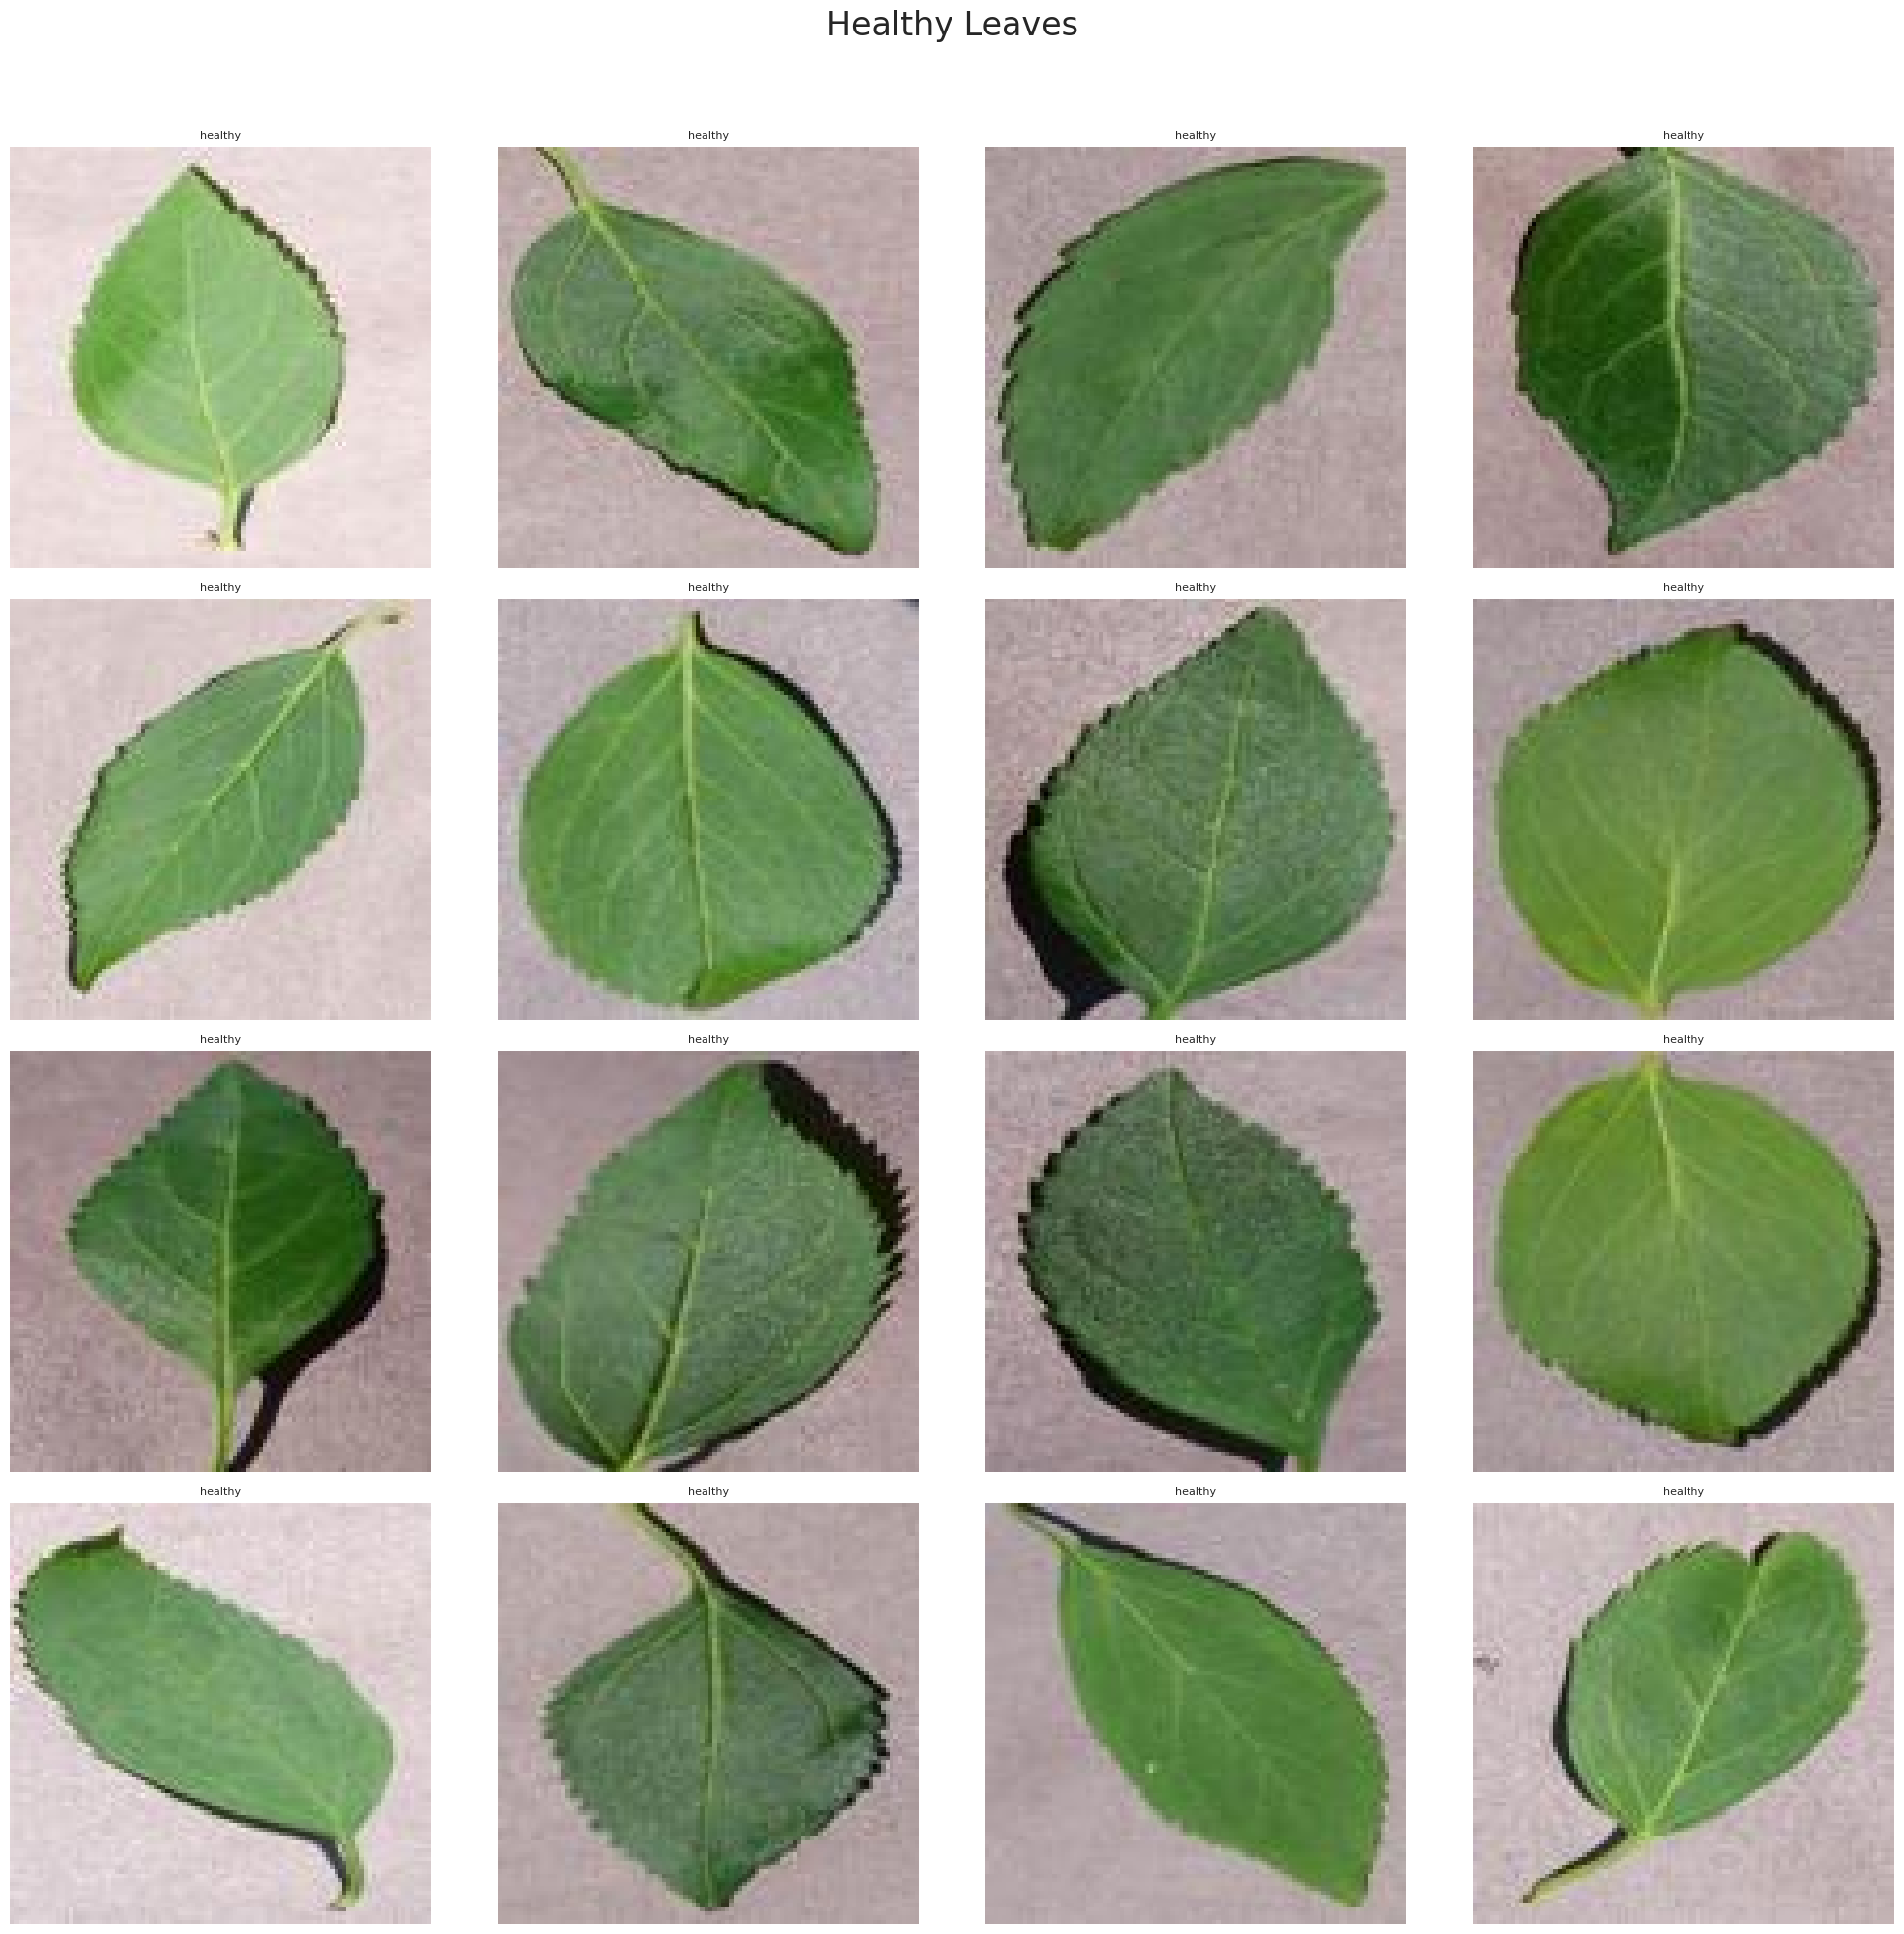

In [21]:
image_montage(sample_healthy_df, 4, 4, title='Healthy Leaves')

---

### Train, Validation, Test Set

The data structure is made up of the parent folder: Cherry leaves with two subset folders: Healthy and Mildew. I will need to restructure the file layout and create a Train, Validation and Test set so data anaylsis can be performed.


In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
                                cherry_df.drop(['label'], axis=1),
                                cherry_df['label'],
                                test_size=0.2,
                                random_state=25
                                )

X_train, X_val, y_train, y_val = train_test_split(
                                X_train,
                                y_train,
                                test_size=0.2,
                                random_state=25
)

print("Train Set:", X_train.shape, y_train.shape)
print("Validation Set:", X_val.shape, y_val.shape)
print("Test Set:", X_test.shape, y_test.shape)

Train Set: (2692, 1) (2692,)
Validation Set: (674, 1) (674,)
Test Set: (842, 1) (842,)


---

---

# Section 2

Section 2 content

---

NOTE

* You may add as many sections as you want, as long as it supports your project workflow.
* All notebook's cells should be run top-down (you can't create a dynamic wherein a given point you need to go back to a previous cell to execute some task, like go back to a previous cell and refresh a variable content)

---

# Push files to Repo

* If you don't need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [ ]:
import os
try:
    # create here your folder
    # os.makedirs(name='')
except Exception as e:
    print(e)
